Simple tool to perform "demux like" operations on trajectories. Currently works with numpy arrays. Could be extended to directly use mdtraj objects.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

This is a function to generate mock trajectories.

- NR: number of replicas
- L: number of frames per replica
- NOBS: number of observables (the larger, the better the macthing)
- TAU: correlation time for observables. The larger, the easier the matching.

In [3]:
def generate_trajs(NR,L,NOBS,tau=10.0):
    c1=np.exp(-1.0/tau)
    c2=np.sqrt(1-c1**2)
    traj=np.random.normal(size=(NR,L,NOBS))
    for i in range(1,L):
        traj[:,i,:]=traj[:,i-1,:]*c1 + traj[:,i,:]*c2
    return traj

This is a tool to artificially scramble the frames. Assumes that trajectory is indexed as [i,j,k]:
- i is the index of the replica
- j is the index of the frame
- k is the index of the observable

Returns a pair with the reference permutation (to be used as a check) and the new trajectory.

permutation[i,j] is "from which continuous replica does the i-th frame of j-th replica come from".

In [4]:
def scramble(traj): 
    # senza creare la traiettoria nuova, il loop è con un iteratore sui frame;
    # passargli 24 file mdtraj aperti, senza tenere in memoria le traiettorie, passo direttamente le coordinate
    # dato che ci sono PBC, calcolo il vettore distanza percorsa da ciascun atomo tra due frame successivi mod lato scatola
    # mdtraj dà anche la matrice della cella; 
    # (leggi frame, inverso matrice cella per avere le coordinate; sin,cos coordinate scalate *2pi per le PBC)
    # usare come osservabili le coordinate (anche il solvente)
    # se è isobara, il volume cambia ma le coordinate scalate comunque cambiano poco
    # poi calcola la distanza euclidea 
    # 
    permutations=[]
    NR=traj.shape[0]
    L=traj.shape[1]
    newt=+traj
    permutations.append(np.arange(NR))
    for i in range(1,L):
        permutations.append(np.random.permutation(NR))
        newt[:,i,:]=traj[permutations[-1],i,:]
    return np.array(permutations),newt

Now the key tool. Takes the scrambled trajectory as an input and try to reconstruct the original one. Returns both the guessed permutation and the original trajectories.

permutation[i,j] is "from which continuous replica does the i-th frame of j-th replica come from".

It is the same as `replica_index.xvg` in gromacs.

In [5]:
def demux(traj):
    from scipy.spatial import distance
    from scipy.optimize import linear_sum_assignment
    NR=traj.shape[0]
    L=traj.shape[1]
    permutations=[]
    permutations.append(np.arange(NR))
    newt=+traj
    for i in range(1,L):
        cost=distance.cdist(traj[:,i,:],traj[:,i-1,:],"sqeuclidean")
        (rows,cols)=linear_sum_assignment(cost)
        permutations.append(permutations[-1][cols])
        newt[permutations[-1],i,:]=traj[:,i,:]
    return np.array(permutations),newt

Success rate: 0.8904166666666666


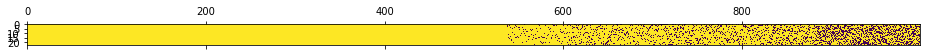

In [10]:
# easy case: long tau and enough observables
NR=24
NOBS=10
L=1000
tau=10
traj=generate_trajs(NR,L,NOBS,tau)
p_true,scambled_traj=scramble(traj)
p_check,demuxed_traj=demux(scambled_traj)
print("Success rate:",np.sum(p_true==p_check)/p_true.size)
plt.matshow((p_true==p_check).T)

In [14]:
print(p_check.shape)
print(p_check[:,0])

(1000, 24)
[ 0 13  0  9  1  3  2 23 23 13 11 18  7  7 22 16  3 11 23  6 20  6  4 17
 11  0 11 12  3  7 11 19 15  5  7 13 23  0  6  1  6  6  3 16  6 18  3 23
 17 16 23  8 22 12  5 17 21 15  0  8 16 20 21 16 18 14 17  9  1 18  7  7
 11  6  5 21 21 17  1  7 18 17 23  5 22  6  8  9 21 13  4 14 22 23 17  2
  3  9  7 18  4 23  3  9 14  2  7  9  6  7 21 16 23 17  7  9  4  1 11  9
  5 12 17 10 10 12 14 13 16 18  6 18  7 16  2  5  3  4 17  1 22  3  9  3
 13 20  3 20  3 15  8 14 10  2 12  3  7 16 18  0 14 18 16  6  0 22  0 18
 13 19 20 20 18 12 18 12 18 12  8  1 19 21 18 10 15  0 11  9 10 22  7 16
 20 10 15 23 12  0 17 11  7  0  9 22  0  7  4 18  8  4 16 15 17  7 22  5
 15 20  0 13  5  4 11 11 14 15 12  8  0  7 18 19  3  7 21 10 21 14 14 17
  7 17 21  2 12 21 10  7 11 22 10  2 14 10 20  7 19  6  5 21  4 23  4  1
  7  8 19  6 20 10  6  0 12 17  3  7  5 20  7  3 19 17 15 21 11 16 13  4
  6  9  9 23 12  5 13 21 15  7 11  3 21  6 22 12  2  5  6 21 10  6  2 14
 20 21 19  0 10 10  9  2 19 13 11  2 10 

Success rate: 0.16625


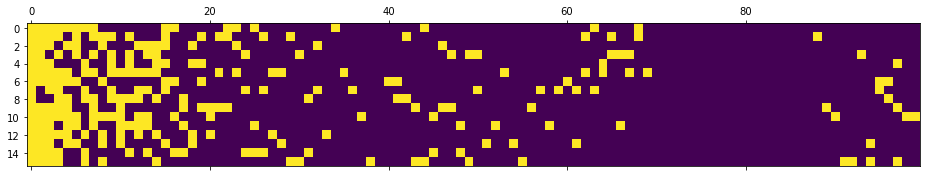

In [6]:
# more difficult case: shorted tau
# notice that errors accumulate
NR=16
NOBS=10
L=100
tau=3
traj=generate_trajs(NR,L,NOBS,tau)
p_true,scambled_traj=scramble(traj)
p_check,demuxed_traj=demux(scambled_traj)
print("Success rate:",np.sum(p_true==p_check)/p_true.size)
plt.matshow((p_true==p_check).T)

Success rate: 1.0


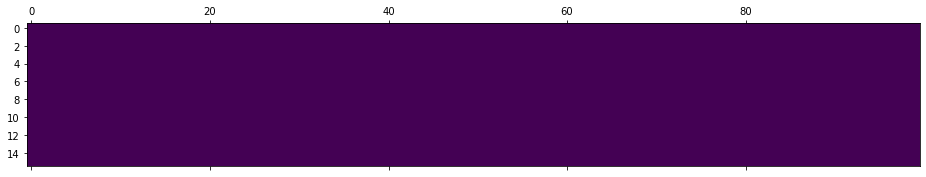

In [7]:
# with more observables, it's easier
NR=16
NOBS=20
L=100
tau=3
traj=generate_trajs(NR,L,NOBS,tau)
p_true,scambled_traj=scramble(traj)
p_check,demuxed_traj=demux(scambled_traj)
print("Success rate:",np.sum(p_true==p_check)/p_true.size)
plt.matshow((p_true==p_check).T)